In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
import mo_pack
from matplotlib import ticker, cm
import iris.analysis.cartography
import aeolus
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube

In [2]:
warnings.filterwarnings("ignore")


# Import the high temporal resolution cloud data

In [9]:
pcb_b = iris.load('../data_b/pcb_bnox_musc_7440_120_2.nc')
pcb_ccz = iris.load('../data_b/pcb_bnox_ccz_highres.nc')

In [10]:
cc_base= pcb_ccz.extract_cube('LOWEST CONV CLOUD BASE LEVEL NO.')
cc_top= pcb_ccz.extract_cube('LOWEST CONV CLOUD TOP LEVEL NO.')

#Import altitude layers from other cube
rf50001 = pcb_b.extract_cube('Stash code = 50001')
avtrf50001 = rf50001.collapsed('t', iris.analysis.MEAN)
z_arr=avtrf50001.coord('Hybrid height')

In [15]:
cc_base[0,0,65,:]

Lowest Conv Cloud Base Level No. (unknown),longitude
Shape,144
Dimension coordinates,
longitude,x
Scalar coordinates,
Lower level (hybrid),-1.0
latitude,41.0 degrees
t,2024-09-25 11:00:00
Attributes,
date,25/09/24
history,Wed Aug 17 13:43:06 UTC 2022 - XCONV V1.92 16-February-2006


# Some standard cube operations

In [5]:
from iris.util import broadcast_to_shape, guess_coord_axis, is_regular
from iris.analysis.cartography import wrap_lons

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume

def _is_longitude_global(lon_points):
    """Return True if array of longitudes covers the whole sphere."""
    dx = np.diff(lon_points)[0]  # assume regular grid
    case_0_360 = ((lon_points[0] - dx) <= 0) and ((lon_points[-1] + dx) >= 360)
    case_pm180 = ((lon_points[0] - dx) <= -180) and ((lon_points[-1] + dx) >= 180)
    return case_0_360 or case_pm180

def roll_cube_pm180(cube_in):
    """
    Take a cube spanning 0...360 degrees in longitude and roll it to -180...180 degrees.

    Works with global model output, and in some cases for regional.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude and latitude coordinates.
    model: aeolus.model.Model, optional
        Model class with a relevant longitude coordinate name.

    Returns
    -------
    iris.cube.Cube

    See also
    --------
    aeolus.coord.roll_cube_0_360
    """
    cube = cube_in.copy()
    #coord_name = model.x  # get the name of the longitude coordinate
    xcoord = cube.coord('longitude')
    if (xcoord.points >= 0.0).all():
        assert is_regular(xcoord), "Operation is only valid for a regularly spaced coordinate."
        if _is_longitude_global(xcoord.points):
            # Shift data symmetrically only when dealing with global cubes
            cube.data = np.roll(cube.data, len(xcoord.points) // 2, axis=-1)

        if xcoord.has_bounds():
            bounds = wrap_lons(xcoord.bounds, -180, 360)  # + subtract
            bounds = bounds[bounds[:, 0].argsort(axis=0)]
        else:
            bounds = None
        cube.replace_coord(
            xcoord.copy(points=np.sort(wrap_lons(xcoord.points, -180, 360)), bounds=bounds)
        )
    else:
        # Nothing to do, the cube is already centered on 0 longitude
        # unless there is something wrong with longitude
        msg = f"Incorrect {coord_name} values: from {xcoord.points.min()} to {xcoord.points.max()}"
        assert ((xcoord.points >= -180.0) & (xcoord.points <= 180.0)).all(), msg
    return cube

def cuberoll_merid(cube_in):
    roll = roll_cube_pm180(cube_in)
    #roll_merid=meridional_mean(roll)
    return roll

# Calculate cloud depths at every coordinate between 40 N/S and at all longitudes

In [17]:
z_arr=avtrf50001.coord('Hybrid height')
z_arr[11]
ccz=[]
for t in range(3556):
    for i in range(25,65):
        for j in range(144):
            czvalues=float(z_arr[int(cc_top.data[t,0,i,j])].points-z_arr[int(cc_base.data[t,0,i,j])].points)
       #print(czvalues[:20])
            ccz.append(czvalues/1000)
        #print(z_arr[int(cc_base.data[0,0,i,1])])

        #max_ccz.append(cc_top.data[0,0,i,j])
        #max_ccz.append(avtrf50001.coord('Hybrid height')[int(cc_top.data[0,0,i,j])])
len(ccz) 


20482560

# Filter positive cloud depths

In [18]:
ccz_nz=[]
for i in range(len(ccz)): 
    if ccz[i]>0:
        ccz_nz.append(ccz[i])
len(ccz_nz)
#max(ccz_nz)

4257937

# Plot histogram of cloud depths at high temporal resolution (Figure 4 in Braam et al. 2022)

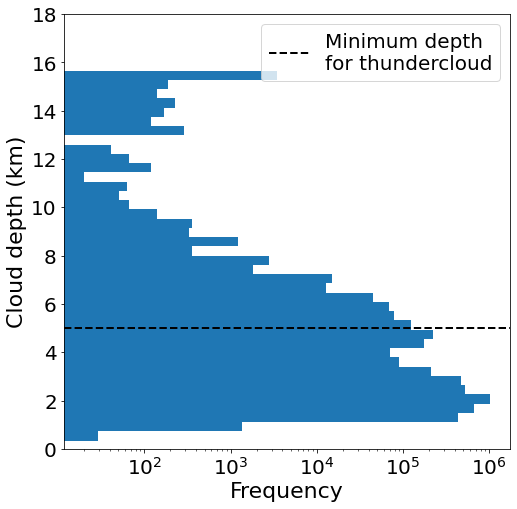

In [19]:
fig=plt.figure(figsize=(8,8))
plt.hist(ccz_nz, bins=40, orientation='horizontal')
plt.ylim(0,18)
plt.xscale('log')
plt.ylabel('Cloud depth (km)', fontsize=22)
plt.xlabel('Frequency', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(5, label='Minimum depth\nfor thundercloud', lw=2, ls='--', color='black')
plt.legend(fontsize=20, loc='upper right')
plt.show()